# Machine Learning EL9123 Project
## Movie Recommender System
#### Team Member
+ Xiantian Sun
+ Yufei Ren
+ Ziyu Su

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import the movies and ratings data
!wget http://files.grouplens.org/datasets/movielens/ml-latest-small.zip && unzip ml-latest-small.zip
movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

/bin/sh: wget: command not found


In [2]:
movies.head(6)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller


In [3]:
ratings.head(6)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
5,1,70,3.0,964982400


In [4]:
N_movies = len(movies)
N_users = np.max(ratings.userId)
X = np.zeros([N_users+1,N_movies+1])
print(X.shape)
N_ratings = ratings.shape[0]
print(N_ratings)

(611, 9743)
100836


There are about 10000 movies, however the range of movieId is over 190000, we use the index of movie for count instead of movieId.

In [5]:
#find all the ratings for each movie
for i in range(N_ratings):
    a=np.where(movies.movieId==ratings.movieId[i])
    X[ratings.userId[i],a[0]] = ratings.rating[i]
print(X[:10,:10])
X.shape

[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [4.  0.  4.  0.  0.  4.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [4.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  4.  5.  3.  5.  4.  4.  3.  0.  3. ]
 [4.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  4.  0.  0.  0.  0.  0.  0.  0.  2. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]


(611, 9743)

In [6]:
#remove the mean for each non-zero value
mean_users = np.zeros(N_users+1)
mean_movies = np.zeros(N_movies+1)

for i in range(N_users+1):
    if np.mean(X[i,:]) == 0:
        mean_users[i] = 0
    else:
        mean_users[i] = np.mean(X[i,np.nonzero(X[i,:])])
for i in range(N_movies+1):
    if np.mean(X[:,i]) == 0:
        mean_movies[i] = 0
    else:
        mean_movies[i] = np.mean(X[np.nonzero(X[:,i]),i])
print(mean_users[:5])
print(mean_movies[:5])

[0.         4.36637931 3.94827586 2.43589744 3.55555556]
[3.92093023 3.43181818 3.25961538 2.35714286 3.07142857]


In [7]:
Xs = np.zeros([N_users+1,N_movies+1])
for i in range(N_users+1):
    for j in range(N_movies+1):
        if X[i,j] != 0:
            Xs[i,j] = X[i,j] - mean_users[i]/2 - mean_movies[j]/2
print(Xs[:10,:10])

[[ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.14365477  0.          0.18700265  0.          0.         -0.15622887
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.22135307  0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.53727562  1.62337702  0.07461328  1.71747043  0.2801455
   0.66059212 -0.18431529  0.         -0.49492135]
 [ 0.9244033   0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.49685687  0.          0.        

In [8]:
print(movies.title.shape[0])

9742


Use K-fold to determine how many PCs we need to get the best accuracy.

In [9]:
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
nfold = 5

# Create a K-fold object
kf = KFold(n_splits=nfold)
kf.get_n_splits(X)

# Number of PCs to try
ncomp_test = np.arange(100,400,10)
print(ncomp_test)
num_nc = len(ncomp_test)

# Accuracy:  acc[icomp,ifold]  is test accuracy when using `ncomp = ncomp_test[icomp]` in fold `ifold`.
RMSE = np.zeros((num_nc,nfold))

# Loop over number of components to test
for icomp, ncomp in enumerate(ncomp_test):
    print(ncomp)
    # Look over the folds
    for ifold, I in enumerate(kf.split(X)):
        Itr, Its = I
        #print(ifold)
        # TODO:  Split data into training 
        Xtr, Xts= Xs[Itr],Xs[Its]
        
        # TODO:  Create a scaling object and fit the scaling on the training data
        pca = PCA(n_components = ncomp)        
        
        # TODO:  Fit the PCA on the scaled training data
        pca.fit(Xtr)
        Ztr = pca.transform(Xtr)        
        
        # TODO:  Transform the test data through data scaler and PCA
        Zts = pca.transform(Xts)
        Xts_hat = np.dot(Zts,pca.components_)
        
        # TODO:  Measure the accuracy 
        RMSE[icomp, ifold] =np.sqrt(np.mean((Xts - Xts_hat)**2))

[100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270
 280 290 300 310 320 330 340 350 360 370 380 390]
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390


[0.10377121 0.10335163 0.1029244  0.10248861 0.10206876 0.10168612
 0.10127309 0.100899   0.10053814 0.10016462 0.09981472 0.09945276
 0.09913547 0.09880444 0.0984613  0.0981467  0.09781774 0.0974954
 0.097165   0.09682891 0.09650271 0.09617306 0.09588818 0.09556176
 0.0952843  0.09499066 0.09468789 0.09439923 0.09411058 0.09380558]
0.09638013017928357
23


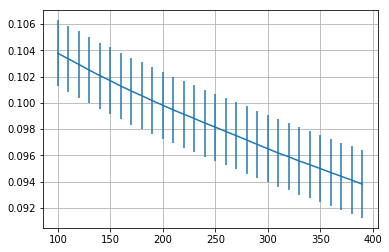

In [10]:
#plot the errorbar
RMSE_mean = np.mean(RMSE,axis=1)
RMSE_se = np.std(RMSE,axis=1)/np.sqrt(nfold-1)
print(RMSE_mean)
plt.errorbar(ncomp_test,RMSE_mean,yerr=RMSE_se,fmt='-')
plt.grid()

n0 = np.argmin(RMSE_mean)
# TODO:  Optimal order with one SE rule
RMSE_tgt = RMSE_mean[n0]+RMSE_se[n0]
print(RMSE_tgt)
i = np.where(RMSE_mean <= RMSE_tgt)
dopt = np.min(i)
print(dopt+2)

In [11]:
from sklearn.decomposition import PCA

ncomp = 10
pca = PCA(n_components=2)
Z = pca.fit_transform(Xs)
print(Z[:5,:5])
print(pca.n_components_)

[[-0.56389207  0.07158431]
 [ 1.53861192  1.21404965]
 [-0.67285588  0.0326309 ]
 [-1.08215214  0.05371388]
 [-1.26477375 -0.32782549]]
2


In [12]:
Xs_hat = np.dot(Z,pca.components_)

print(Xs[:5,:5])
print(Xs_hat[:5,:5])

[[ 0.          0.          0.          0.          0.        ]
 [-0.14365477  0.          0.18700265  0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]]
[[-0.01290107  0.01565239  0.0022831   0.00115698  0.01761968]
 [ 0.11973387  0.02583771  0.0438734   0.00642636 -0.03526389]
 [-0.01856006  0.01610969  0.00084774  0.00102163  0.02054455]
 [-0.0297761   0.02596916  0.00140727  0.00165147  0.03305296]
 [-0.05822905  0.01135426 -0.01224116 -0.00072581  0.03507997]]


In [13]:
X_hat = Xs_hat + mean_movies/2
X_hat = (X_hat.T + mean_users.T/2).T
print(X_hat[:5,:5])

[[1.94756404 1.73156148 1.63209079 1.17972841 1.55333397]
 [4.26338865 3.92493645 3.85687075 3.36818744 3.68364005]
 [3.91604298 3.70615671 3.60479336 3.15373099 3.53039677]
 [3.14863773 2.95982697 2.84916368 2.39817161 2.78671596]
 [3.68001385 3.50504112 3.39534431 2.9556234  3.34857203]]


In [14]:
Y = 5*(X_hat+np.min(X_hat))/(np.max(X_hat)+np.min(X_hat))

In [17]:
import re
def recommend(user, k=5):
    recomm = []
    np_movie_Id = np.array(movies.movieId)
#     np_movie_title = np.array(movies.title)
    for i in range(Y.shape[1]):
      n = np.argwhere(np_movie_Id==i)
      if len(n)>0 and X[user,i] == 0:
#           print(n)
          s = str(movies.title[n[0]])
          s = re.sub('\nName: title, dtype: object', '', s)
          recomm.append((s, Y[user,i]))
    recomm.sort(key=lambda val:val[1], reverse=True)
    return recomm[:k]        

In [18]:
#Recommend movies for user 1
RECOM = recommend(1)
print (RECOM)

[('3248    Rape Me (Baise-moi) (2000)', 3.3283647665525002), ('2218    Goldfinger (1964)', 3.3278125327181014), ('2845    Sinbad and the Eye of the Tiger (1977)', 3.3278125327181014), ('2881    Tao of Steve, The (2000)', 3.3278125327181014), ('2913    Urban Legends: Final Cut (2000)', 3.318856691084882)]
